In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [ ]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import zipfile
import string
from collections import defaultdict
from sklearn.metrics import accuracy_score
import difflib
import warnings
warnings.filterwarnings('ignore')

import matplotlib
matplotlib.use('Agg')
import matplotlib.pyplot as plt

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")

TensorFlow version: 2.19.0


In [ ]:
img_height, img_width = 50, 200
batch_size = 16
characters = sorted(list(set(string.ascii_letters + string.digits)))

char_to_num = layers.StringLookup(vocabulary=list(characters), mask_token=None)
num_to_char = layers.StringLookup(
    vocabulary=char_to_num.get_vocabulary(), mask_token=None, invert=True
)

vocab_size = len(char_to_num.get_vocabulary())
print(f"Vocabulary size: {vocab_size}")

Vocabulary size: 63


In [ ]:
def extract_datasets():
    files_to_extract = [
        ('/content/drive/MyDrive/ColabDatasets/captcha_final.zip', 'captcha_final'),
        ('/content/drive/MyDrive/ColabDatasets/test_captcha.zip', 'test_captcha')
    ]

    for zip_path, extract_name in files_to_extract:
        if os.path.exists(zip_path):
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall('.')
            print(f"Extracted {extract_name}")
        else:
            print(f"File not found: {zip_path}")

def load_data_paths(csv_path, folder_name):
    if not os.path.exists(csv_path):
        print(f"CSV file not found: {csv_path}")
        return [], []

    df = pd.read_csv(csv_path)
    image_paths = []
    labels = []

    # Handle nested folder structure
    if os.path.exists(os.path.join(folder_name, folder_name)):
        actual_folder = os.path.join(folder_name, folder_name)
    else:
        actual_folder = folder_name

    if not os.path.exists(actual_folder):
        print(f"Folder not found: {actual_folder}")
        return [], []

    for _, row in df.iterrows():
        img_path = os.path.join(actual_folder, row['filename'])
        if os.path.exists(img_path):
            image_paths.append(img_path)
            label = str(row['text'])[:5]
            labels.append(label)

    print(f"Loaded {len(image_paths)} samples")
    return image_paths, labels

extract_datasets()

train_paths, train_labels = load_data_paths(
    '/content/drive/MyDrive/ColabDatasets/labels_final.csv',
    'captcha_final'
)

test_paths, test_labels = load_data_paths(
    '/content/drive/MyDrive/ColabDatasets/test_data.csv',
    'test_captcha'
)

print(f"Training samples: {len(train_paths)}")
print(f"Test samples: {len(test_paths)}")

Extracted captcha_final
Extracted test_captcha
Loaded 6208 samples
Loaded 367 samples
Training samples: 6208
Test samples: 367


In [ ]:
def encode_single_sample(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.io.decode_png(img, channels=1)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = 1.0 - img

    def remove_lines(x, ksize=2):
        eroded = -tf.nn.max_pool(-x[None, ...], ksize=[1, ksize, ksize, 1],
                                 strides=[1, 1, 1, 1], padding="SAME")
        opened = tf.nn.max_pool(eroded, ksize=[1, ksize, ksize, 1],
                                strides=[1, 1, 1, 1], padding="SAME")
        return opened[0]

    img = remove_lines(img)
    img = 1 - img

    img = tf.image.random_brightness(img, 0.1)
    img = tf.image.random_contrast(img, 0.8, 1.2)
    img = tf.clip_by_value(img, 0.0, 1.0)

    img = tf.image.resize(img, [img_height, img_width])
    img = tf.transpose(img, perm=[1, 0, 2])

    label = char_to_num(tf.strings.unicode_split(label, "UTF-8"))
    input_length = tf.shape(img)[0:1] // 8
    label_length = tf.shape(label)[0:1]

    return {
        "image": img,
        "label": label,
        "input_length": input_length,
        "label_length": label_length
    }

def split_data(images, labels, train_size=0.9, shuffle=True):
    size = tf.shape(images)[0]
    indices = tf.range(size)
    if shuffle:
        indices = tf.random.shuffle(indices)
    train_samples = tf.cast(tf.floor(tf.cast(size, tf.float32) * train_size), tf.int32)
    train_idx, valid_idx = indices[:train_samples], indices[train_samples:]
    x_train, y_train = tf.gather(images, train_idx), tf.gather(labels, train_idx)
    x_valid, y_valid = tf.gather(images, valid_idx), tf.gather(labels, valid_idx)
    return x_train, x_valid, y_train, y_valid

print("Preprocessing functions ready")

Preprocessing functions ready


In [ ]:
if len(train_paths) > 0:
    train_paths_tensor = tf.constant(train_paths)
    train_labels_tensor = tf.constant(train_labels)

    x_train, x_valid, y_train, y_valid = split_data(train_paths_tensor, train_labels_tensor)

    print(f"Training: {len(x_train)}, Validation: {len(x_valid)}")

    train_dataset = tf.data.Dataset.from_tensor_slices((x_train, y_train))
    train_dataset = (
        train_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                     .cache()
                     .shuffle(2000)
                     .batch(48)
                     .prefetch(tf.data.AUTOTUNE)
    )

    validation_dataset = tf.data.Dataset.from_tensor_slices((x_valid, y_valid))
    validation_dataset = (
        validation_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                          .cache()
                          .batch(48)
                          .prefetch(tf.data.AUTOTUNE)
    )

    if len(test_paths) > 0:
        test_paths_tensor = tf.constant(test_paths)
        test_labels_tensor = tf.constant(test_labels)
        test_dataset = tf.data.Dataset.from_tensor_slices((test_paths_tensor, test_labels_tensor))
        test_dataset = (
            test_dataset.map(encode_single_sample, num_parallel_calls=tf.data.AUTOTUNE)
                        .cache()
                        .batch(48)
                        .prefetch(tf.data.AUTOTUNE)
        )

    print("Datasets created")

Training: 5587, Validation: 621
Datasets created


In [ ]:
if len(train_paths) > 0:
    _, ax = plt.subplots(4, 4, figsize=(12, 8))
    for batch in train_dataset.take(1):
        images = batch["image"]
        labels = batch["label"]

        for i in range(16):
            img = (images[i] * 255).numpy().astype("uint8")
            label = tf.strings.reduce_join(num_to_char(labels[i])).numpy().decode("utf-8")
            ax[i // 4, i % 4].imshow(img[:, :, 0].T, cmap="gray")
            ax[i // 4, i % 4].set_title(label)
            ax[i // 4, i % 4].axis("off")
    plt.tight_layout()
    plt.savefig('sample_images.png', dpi=100, bbox_inches='tight')
    print("Sample images saved")
    plt.close()

Sample images saved


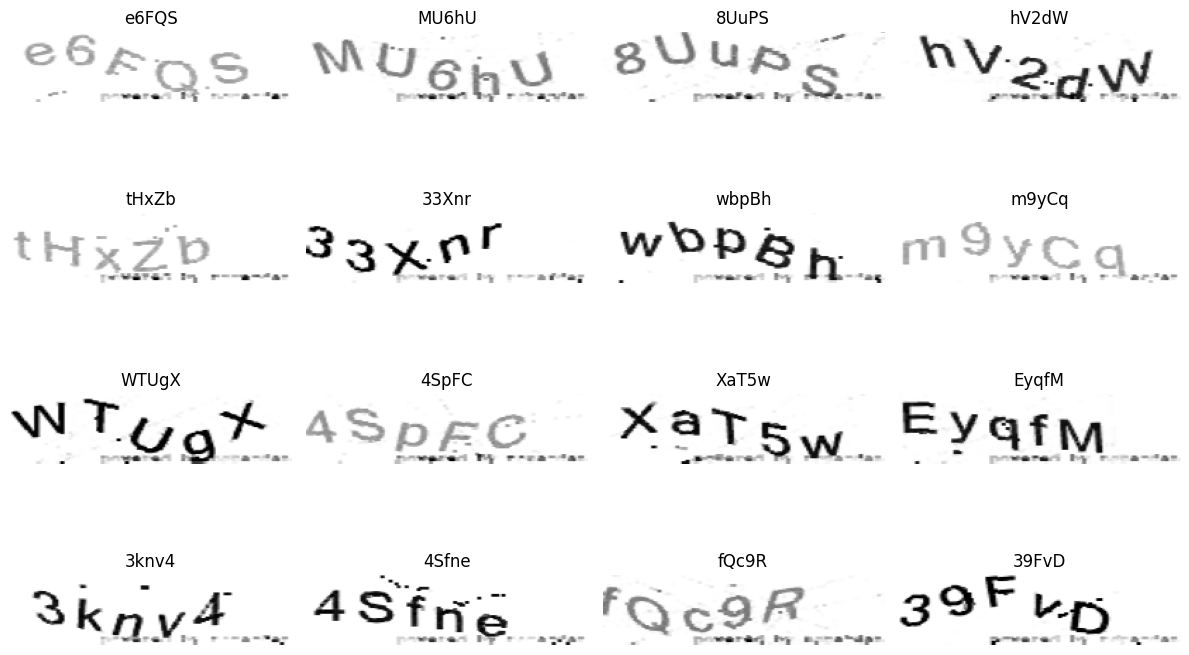

In [ ]:
from IPython.display import Image, display
display(Image('sample_images.png'))

In [ ]:
@tf.keras.utils.register_keras_serializable()
class CTCLayer(layers.Layer):
    def __init__(self, name=None, **kwargs):
        super().__init__(name=name, **kwargs)
        self.loss_fn = keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred, input_length, label_length):
        loss = self.loss_fn(y_true, y_pred, input_length, label_length)
        self.add_loss(loss)
        return y_pred

    def get_config(self):
        return super().get_config()

    @classmethod
    def from_config(cls, config):
        return cls(**config)

def build_ctc_model(img_width, img_height, vocab_size):
    input_img = layers.Input(shape=(img_width, img_height, 1), name="image")

    x = layers.Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.15)(x)

    x = layers.Conv2D(64, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.2)(x)

    x = layers.Conv2D(96, (3, 3), activation='relu', padding='same')(x)
    x = layers.BatchNormalization()(x)
    x = layers.MaxPooling2D((2, 2))(x)
    x = layers.Dropout(0.25)(x)

    new_shape = (img_width // 8, (img_height // 8) * 96)
    x = layers.Reshape(target_shape=new_shape)(x)

    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)

    x = layers.Bidirectional(layers.LSTM(96, return_sequences=True))(x)
    x = layers.Dropout(0.35)(x)

    x = layers.Dense(vocab_size + 1, activation="softmax")(x)

    labels = layers.Input(name="label", shape=(None,), dtype="int32")
    input_length = layers.Input(name="input_length", shape=(1,), dtype="int32")
    label_length = layers.Input(name="label_length", shape=(1,), dtype="int32")

    ctc_output = CTCLayer(name="ctc_loss")(labels, x, input_length, label_length)

    model = keras.models.Model(
        inputs=[input_img, labels, input_length, label_length],
        outputs=ctc_output
    )

    model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.001))
    return model

if len(train_paths) > 0:
    model = build_ctc_model(img_width, img_height, vocab_size)
    print("Model created")
    model.summary()

Model created


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ image (InputLayer)  │ (None, 200, 50,   │          0 │ -                 │
│                     │ 1)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 200, 50,   │        320 │ image[0][0]       │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 200, 50,   │        128 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 100, 25,   │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 100, 25,   │          0 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 100, 25,   │     18,496 │ dropout[0][0]     │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 100, 25,   │        256 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 50, 12,    │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 50, 12,    │          0 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 50, 12,    │     55,392 │ dropout_1[0][0]   │
│                     │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 50, 12,    │        384 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 96)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 25, 6, 96) │          0 │ batch_normalizat… │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 25, 6, 96) │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ reshape (Reshape)   │ (None, 25, 576)   │          0 │ dropout_2[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 25, 128)   │     73,856 │ reshape[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_3 (Dropout) │ (None, 25, 128)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ bidirectional       │ (None, 25, 192)   │    172,800 │ dropout_3[0][0]   │
│ (Bidirectional)     │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_4 (Dropout) │ (None, 25, 192)   │          0 │ bidirectional[0]… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 333,984 (1.27 MB)

 Trainable params: 333,600 (1.27 MB)

 Non-trainable params: 384 (1.50 KB)

In [ ]:
if len(train_paths) > 0 and 'model' in locals():
    callbacks = [
        keras.callbacks.EarlyStopping(
            monitor="val_loss",
            patience=8,
            restore_best_weights=True,
            verbose=1,
            min_delta=0.005
        ),
        keras.callbacks.ReduceLROnPlateau(
            monitor="val_loss",
            factor=0.5,
            patience=4,
            verbose=1,
            min_lr=1e-6
        ),
        keras.callbacks.ModelCheckpoint(
            'improved_final_model.keras',
            monitor='val_loss',
            save_best_only=True,
            verbose=1
        )
    ]

    epochs = 80
    history = model.fit(
        train_dataset,
        validation_data=validation_dataset,
        epochs=epochs,
        callbacks=callbacks,
        verbose=1
    )

    model.save('improved_final_model.h5')
    print("Training completed")

Epoch 1/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step - loss: 1317.8822
Epoch 1: val_loss improved from inf to 1118.95020, saving model to improved_final_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 24s 114ms/step - loss: 1316.0161 - val_loss: 1118.9502 - learning_rate: 0.0010
Epoch 2/80
116/117 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - loss: 1026.8479
Epoch 2: val_loss improved from 1118.95020 to 1032.02759, saving model to improved_final_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 8s 66ms/step - loss: 1026.8007 - val_loss: 1032.0276 - learning_rate: 0.0010
Epoch 3/80
116/117 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step - loss: 1020.6754
Epoch 3: val_loss improved from 1032.02759 to 1014.26813, saving model to improved_final_model.keras
117/117 ━━━━━━━━━━━━━━━━━━━━ 9s 73ms/step - loss: 1020.5916 - val_loss: 1014.2681 - learning_rate: 0.0010
Epoch 4/80
117/117 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step - loss: 961.4208
Epoch 4: val_loss improved from 1014.26813 to 984.20129, saving model to improved_final_model.keras
1

Training completed


In [13]:
if len(train_paths) > 0 and 'history' in locals():
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss', linewidth=2, color='blue')
    plt.plot(history.history['val_loss'], label='Validation Loss', linewidth=2, color='orange')
    plt.title('Model Loss', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True, alpha=0.3)

    plt.subplot(1, 2, 2)
    gap = np.array(history.history['val_loss']) - np.array(history.history['loss'])
    plt.plot(gap, linewidth=2, color='red')
    plt.title('Overfitting Gap', fontweight='bold', fontsize=14)
    plt.xlabel('Epoch')
    plt.ylabel('Loss Difference')
    plt.grid(True, alpha=0.3)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)

    plt.tight_layout()
    plt.savefig('training_history.png', dpi=100, bbox_inches='tight')
    print("Training history saved")
    plt.close()

    print(f"Best val loss: {min(history.history['val_loss']):.4f}")
    print(f"Final train loss: {history.history['loss'][-1]:.4f}")
    print(f"Final val loss: {history.history['val_loss'][-1]:.4f}")

    final_gap = history.history['val_loss'][-1] - history.history['loss'][-1]
    print(f"Final overfitting gap: {final_gap:.4f}")

Training history saved
Best val loss: 11.8955
Final train loss: 13.0834
Final val loss: 12.1118
Final overfitting gap: -0.9716


Training History:


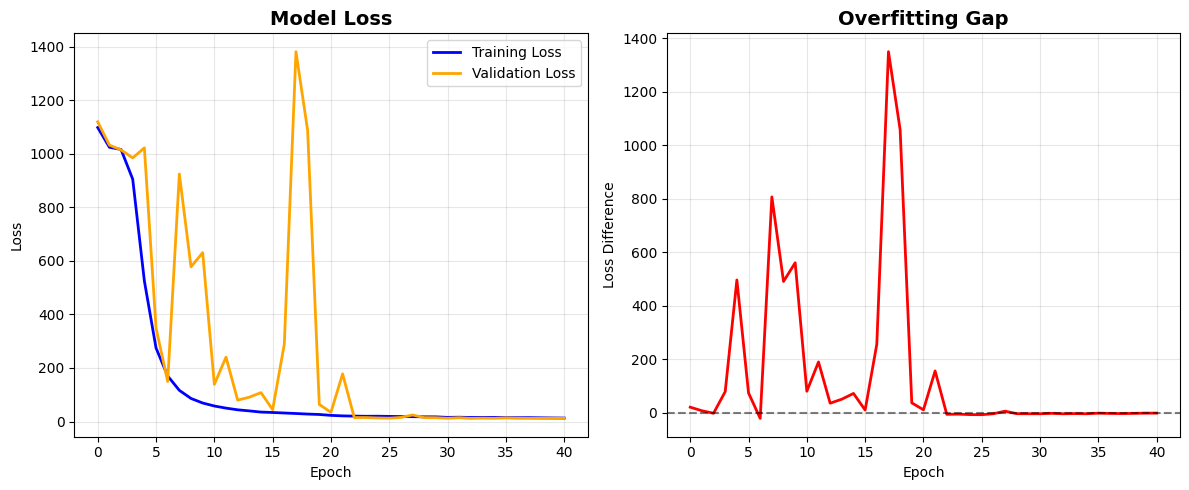

In [14]:
print("Training History:")
display(Image('training_history.png'))

In [15]:
try:
    model = keras.models.load_model('improved_final_model.keras', custom_objects={'CTCLayer': CTCLayer})

    dense_layer = None
    for layer in reversed(model.layers):
        if 'dense' in layer.name.lower() and 'ctc' not in layer.name.lower():
            dense_layer = layer
            break

    if dense_layer:
        prediction_model = keras.models.Model(
            inputs=model.inputs[0],
            outputs=dense_layer.output
        )
        print("Prediction model created")
    else:
        prediction_model = keras.models.Model(
            inputs=model.inputs[0],
            outputs=model.layers[-2].output
        )

except Exception as e:
    print(f"Error: {e}")
    model = build_ctc_model(img_width, img_height, vocab_size)
    model.load_weights('improved_final_model.keras')

    prediction_model = keras.models.Model(
        inputs=model.inputs[0],
        outputs=model.layers[-2].output
    )

def decode_batch_predictions(pred):
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    results = keras.backend.ctc_decode(pred, input_length=input_len, greedy=True)[0][0]
    output_text = []
    for res in results:
        res = tf.gather(res, tf.where(tf.not_equal(res, -1)))
        res = tf.strings.reduce_join(num_to_char(res)).numpy().decode("utf-8")
        output_text.append(res[:5])
    return output_text

print("Ready for predictions")

Prediction model created
Ready for predictions


In [16]:
val_predictions = []
val_true_labels = []
val_images_for_display = []

if 'prediction_model' in locals():
    for batch_num, batch in enumerate(validation_dataset):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        batch_true_texts = []
        for i in range(tf.shape(batch_labels)[0]):
            true_text = tf.strings.reduce_join(num_to_char(batch_labels[i])).numpy().decode("utf-8")
            batch_true_texts.append(true_text)

        preds = prediction_model.predict(batch_images, verbose=0)
        pred_texts = decode_batch_predictions(preds)

        val_predictions.extend(pred_texts)
        val_true_labels.extend(batch_true_texts)

        if batch_num == 0:
            val_images_for_display = batch_images.numpy()

    print(f"Processed {len(val_predictions)} validation samples")

Processed 621 validation samples


In [17]:
def calculate_character_accuracy(true_texts, pred_texts):
    total_chars = 0
    correct_chars = 0

    for true_text, pred_text in zip(true_texts, pred_texts):
        max_len = max(len(true_text), len(pred_text))
        true_padded = true_text.ljust(max_len)
        pred_padded = pred_text.ljust(max_len)

        total_chars += max_len
        for t, p in zip(true_padded, pred_padded):
            if t == p:
                correct_chars += 1

    return correct_chars / total_chars if total_chars > 0 else 0

def calculate_sequence_accuracy(true_texts, pred_texts):
    correct = sum(1 for true_text, pred_text in zip(true_texts, pred_texts) if true_text == pred_text)
    return correct / len(true_texts)

def calculate_edit_distance_similarity(true_texts, pred_texts):
    similarities = []
    for true_text, pred_text in zip(true_texts, pred_texts):
        similarity = difflib.SequenceMatcher(None, true_text, pred_text).ratio()
        similarities.append(similarity)
    return np.mean(similarities)

if val_predictions:
    val_char_accuracy = calculate_character_accuracy(val_true_labels, val_predictions)
    val_seq_accuracy = calculate_sequence_accuracy(val_true_labels, val_predictions)
    val_similarity = calculate_edit_distance_similarity(val_true_labels, val_predictions)

    print("VALIDATION RESULTS:")
    print(f"Character Accuracy: {val_char_accuracy:.4f}")
    print(f"Sequence Accuracy: {val_seq_accuracy:.4f}")
    print(f"Similarity Score: {val_similarity:.4f}")

VALIDATION RESULTS:
Character Accuracy: 0.9926
Sequence Accuracy: 0.9646
Similarity Score: 0.9926


In [18]:
if val_predictions and val_images_for_display is not None:
    plt.figure(figsize=(15, 10))

    num_samples = min(16, len(val_predictions))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)

        if i < len(val_images_for_display):
            img = (val_images_for_display[i] * 255).astype("uint8")
            plt.imshow(img[:, :, 0].T, cmap="gray")

        true_label = val_true_labels[i]
        pred_label = val_predictions[i]
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=color, fontweight='bold')
        plt.axis("off")

    plt.tight_layout()
    plt.savefig('validation_predictions.png', dpi=100, bbox_inches='tight')
    print("Validation predictions saved as validation_predictions.png")
    plt.close()

    print("\nSample Predictions:")
    for i in range(min(10, len(val_predictions))):
        status = "OK" if val_true_labels[i] == val_predictions[i] else "X"
        print(f"{status} True: {val_true_labels[i]} | Pred: {val_predictions[i]}")

Validation predictions saved as validation_predictions.png

Sample Predictions:
OK True: n8EwR | Pred: n8EwR
OK True: Ms2nv | Pred: Ms2nv
OK True: Uw5tp | Pred: Uw5tp
OK True: XnyWF | Pred: XnyWF
OK True: 9NquQ | Pred: 9NquQ
OK True: bW7wW | Pred: bW7wW
OK True: T8te6 | Pred: T8te6
OK True: meQ6K | Pred: meQ6K
OK True: H2b8d | Pred: H2b8d
OK True: ZxZGm | Pred: ZxZGm



Validation Predictions:


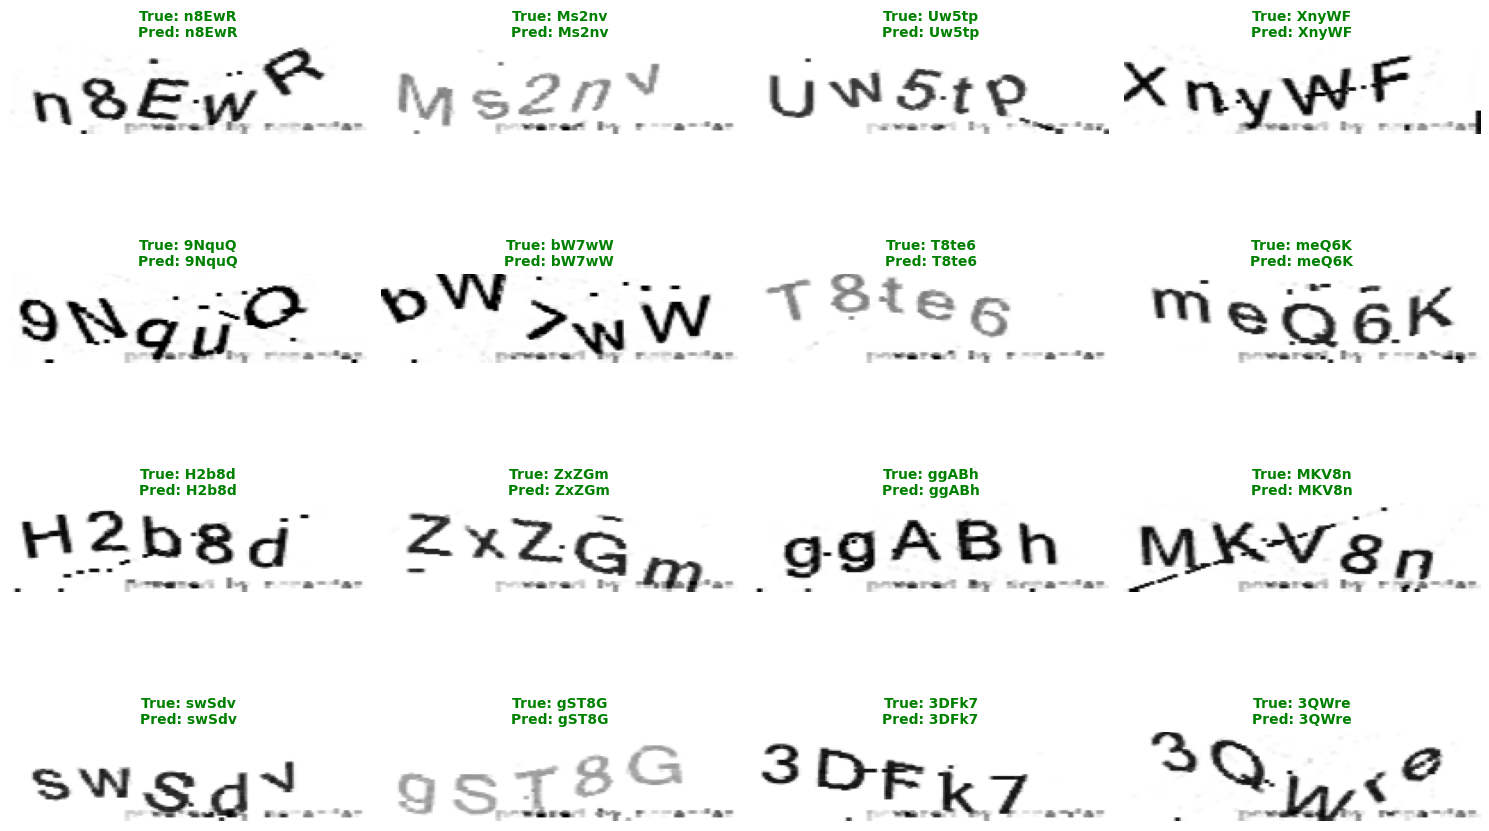

In [19]:
print("\nValidation Predictions:")
display(Image('validation_predictions.png'))

In [20]:
test_predictions = []
test_true_labels = []
test_images_for_display = []

if 'prediction_model' in locals() and 'test_dataset' in globals():
    for batch_num, batch in enumerate(test_dataset):
        batch_images = batch["image"]
        batch_labels = batch["label"]

        batch_true_texts = []
        for i in range(tf.shape(batch_labels)[0]):
            true_text = tf.strings.reduce_join(num_to_char(batch_labels[i])).numpy().decode("utf-8")
            batch_true_texts.append(true_text)

        preds = prediction_model.predict(batch_images, verbose=0)
        pred_texts = decode_batch_predictions(preds)

        test_predictions.extend(pred_texts)
        test_true_labels.extend(batch_true_texts)

        if batch_num == 0:
            test_images_for_display = batch_images.numpy()

    print(f"Processed {len(test_predictions)} test samples")

Processed 367 test samples


In [21]:
if test_predictions:
    test_char_accuracy = calculate_character_accuracy(test_true_labels, test_predictions)
    test_seq_accuracy = calculate_sequence_accuracy(test_true_labels, test_predictions)
    test_similarity = calculate_edit_distance_similarity(test_true_labels, test_predictions)

    print("TEST RESULTS:")
    print(f"Character Accuracy: {test_char_accuracy:.4f}")
    print(f"Sequence Accuracy: {test_seq_accuracy:.4f}")
    print(f"Similarity Score: {test_similarity:.4f}")

TEST RESULTS:
Character Accuracy: 0.9940
Sequence Accuracy: 0.9700
Similarity Score: 0.9940


In [22]:
if test_predictions and test_images_for_display is not None:
    plt.figure(figsize=(15, 10))

    num_samples = min(16, len(test_predictions))
    for i in range(num_samples):
        plt.subplot(4, 4, i + 1)

        if i < len(test_images_for_display):
            img = (test_images_for_display[i] * 255).astype("uint8")
            plt.imshow(img[:, :, 0].T, cmap="gray")

        true_label = test_true_labels[i]
        pred_label = test_predictions[i]
        color = 'green' if true_label == pred_label else 'red'

        plt.title(f"True: {true_label}\nPred: {pred_label}", fontsize=10, color=color, fontweight='bold')
        plt.axis("off")

    plt.tight_layout()
    plt.savefig('test_predictions.png', dpi=100, bbox_inches='tight')
    print("Test predictions saved as test_predictions.png")
    plt.close()

    print("\nSample Test Predictions:")
    for i in range(min(10, len(test_predictions))):
        status = "OK" if test_true_labels[i] == test_predictions[i] else "X"
        print(f"{status} True: {test_true_labels[i]} | Pred: {test_predictions[i]}")

Test predictions saved as test_predictions.png

Sample Test Predictions:
OK True: U8hDr | Pred: U8hDr
OK True: Qf6ak | Pred: Qf6ak
OK True: pDmZq | Pred: pDmZq
OK True: H9Mdd | Pred: H9Mdd
OK True: vQrgk | Pred: vQrgk
OK True: rwEZF | Pred: rwEZF
OK True: 3PgeP | Pred: 3PgeP
OK True: TbenF | Pred: TbenF
OK True: 8bWfa | Pred: 8bWfa
OK True: sFycY | Pred: sFycY



Test Predictions:


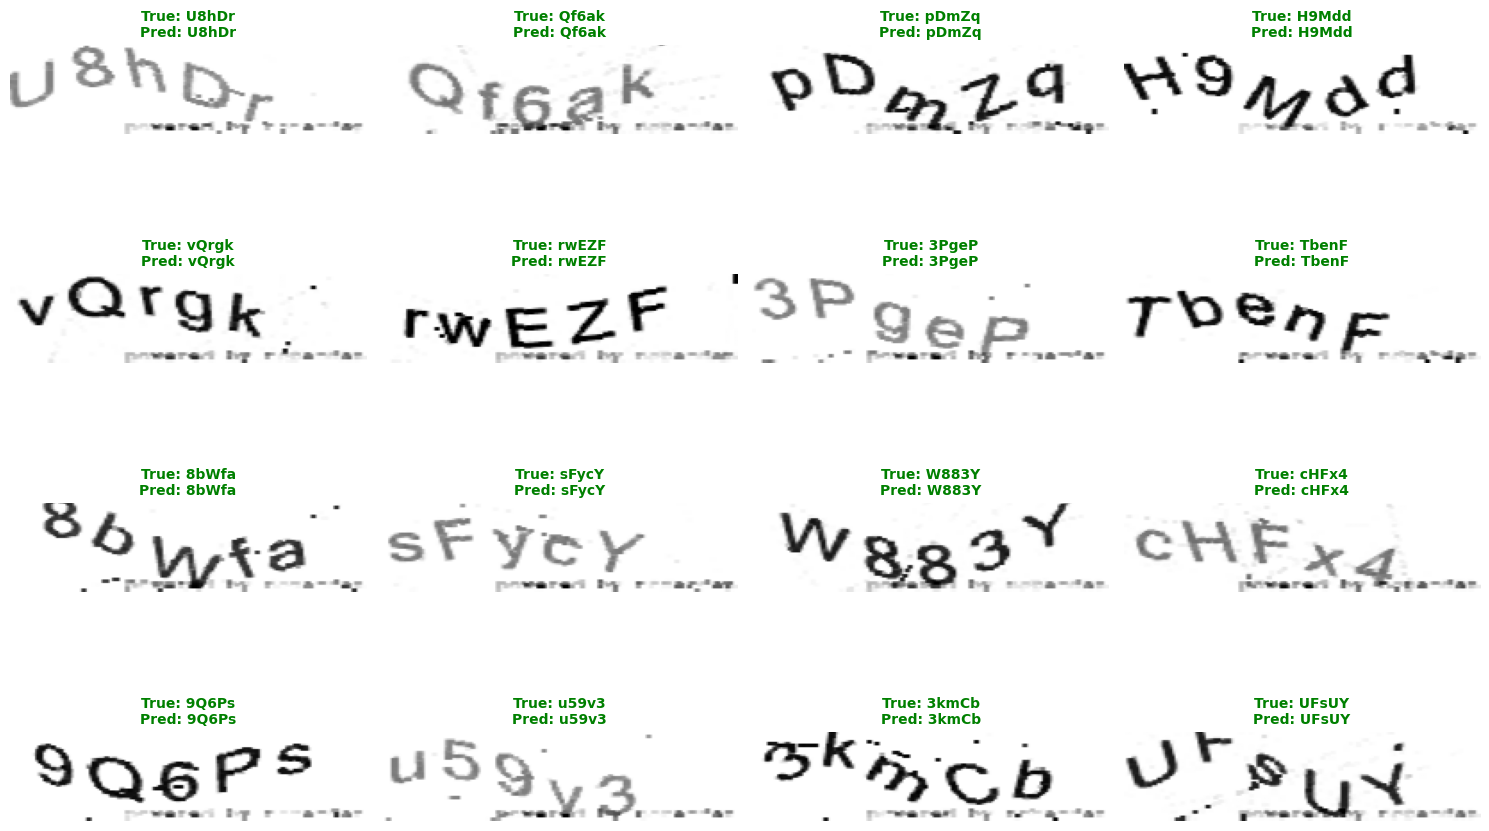

In [23]:
print("\nTest Predictions:")
display(Image('test_predictions.png'))

In [24]:
if val_predictions and test_predictions:
    print("\nFINAL SUMMARY")
    print(f"{'Metric':<25} {'Validation':<15} {'Test':<15}")
    print(f"{'Character Accuracy':<25} {val_char_accuracy:.4f}{'':<11} {test_char_accuracy:.4f}")
    print(f"{'Sequence Accuracy':<25} {val_seq_accuracy:.4f}{'':<11} {test_seq_accuracy:.4f}")
    print(f"{'Similarity Score':<25} {val_similarity:.4f}{'':<11} {test_similarity:.4f}")

    results_df = pd.DataFrame({
        'true_label': test_true_labels,
        'predicted_label': test_predictions,
        'correct': [t == p for t, p in zip(test_true_labels, test_predictions)]
    })
    results_df.to_csv('test_results.csv', index=False)

    val_results_df = pd.DataFrame({
        'true_label': val_true_labels,
        'predicted_label': val_predictions,
        'correct': [t == p for t, p in zip(val_true_labels, val_predictions)]
    })
    val_results_df.to_csv('validation_results.csv', index=False)

    print("\nResults saved to CSV files")


FINAL SUMMARY
Metric                    Validation      Test           
Character Accuracy        0.9926            0.9940
Sequence Accuracy         0.9646            0.9700
Similarity Score          0.9926            0.9940

Results saved to CSV files
